# Praparing work

## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

## Folder dir for saving and loading files

In [2]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

# Robot modelling

## Create joint variables and define their relations

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# q3 = -q2 + q8
# q9 = -q8 + q2

## DH definition in the order of joint_type, a, alpha, d, theta, dh_type, prev, succ

In [4]:
#robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0),
#                      (1,   0,  [2],    0,      0,              -0.21537,   q1),
#                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2),
#                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2)],
#                     dh_convention='mdh',
#                     friction_type=['Coulomb', 'viscous', 'offset'])

robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0),
                      (1,   0,  [2],    0,      0,              -0.21537,   q1),
                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2),
                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2)],
                     dh_convention='mdh',
                     friction_type=[])

[q1, q2, q3]


In [5]:
robot_def.m

[0, m₁, m₂, m₃]

## Create kinematics chain

In [6]:
geom = Geometry(robot_def)


pos_c1
v_cw1
dR_t1
subs dq1
w_b


pos_c2
v_cw2


dR_t2
subs dq2
w_b


pos_c3
v_cw3


dR_t3
subs dq3
w_b


pos_c
[0, Matrix([
[l1x*cos(q1)/m1 - l1y*sin(q1)/m1],
[l1x*sin(q1)/m1 + l1y*cos(q1)/m1],
[               l1z/m1 - 0.21537]]), Matrix([
[-l2x*sin(q2)*cos(q1)/m2 - l2y*cos(q1)*cos(q2)/m2 - l2z*sin(q1)/m2],
[-l2x*sin(q1)*sin(q2)/m2 - l2y*sin(q1)*cos(q2)/m2 + l2z*cos(q1)/m2],
[                       -l2x*cos(q2)/m2 + l2y*sin(q2)/m2 - 0.21537]]), Matrix([
[l3x*(sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3))/m3 + l3y*(sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))/m3 - l3z*sin(q1)/m3 - 0.279*sin(q2)*cos(q1)],
[l3x*(sin(q1)*sin(q2)*sin(q3) - sin(q1)*cos(q2)*cos(q3))/m3 + l3y*(sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2))/m3 + l3z*cos(q1)/m3 - 0.279*sin(q1)*sin(q2)],
[                                              l3x*(sin(q2)*cos(q3) + sin(q3)*cos(q2))/m3 + l3y*(-sin(q2)*sin(q3) + cos(q2)*cos(q3))/m3 - 0.279*cos(q2) - 0.21537]])]
v_cw
[0, Matrix([
[-dq1*(l1x*sin(q1) + l1y*cos(q1))/m1],
[ dq1*(l1x*cos(q1) - l1y*sin(q1))/m1],
[                                  0]]), Matrix([
[ (dq1*

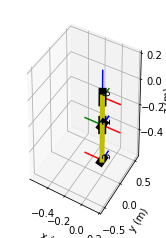

In [8]:
geom.draw_geom()

## Create dynamics object


In [9]:
dyn = Dynamics(robot_def, geom)


('k_e:', L1zz*dq1**2/2)


('k_e:', L2xx*dq1**2*cos(2*q2)/4 + L2xx*dq1**2/4 - L2xy*dq1**2*sin(2*q2)/2 - L2xz*dq1*dq2*cos(q2) - L2yy*dq1**2*cos(2*q2)/4 + L2yy*dq1**2/4 + L2yz*dq1*dq2*sin(q2) + L2zz*dq2**2/2)


('k_e:', -0.25*L3xx*dq1**2*cos(2*q2 + 2*q3) + 0.25*L3xx*dq1**2 + 0.5*L3xy*dq1**2*sin(2*q2 + 2*q3) + 1.0*L3xz*dq1*dq2*sin(q2 + q3) + 1.0*L3xz*dq1*dq3*sin(q2 + q3) + 0.25*L3yy*dq1**2*cos(2*q2 + 2*q3) + 0.25*L3yy*dq1**2 + 1.0*L3yz*dq1*dq2*cos(q2 + q3) + 1.0*L3yz*dq1*dq3*cos(q2 + q3) + 0.5*L3zz*dq2**2 + 1.0*L3zz*dq2*dq3 + 0.5*L3zz*dq3**2 - 0.1395*dq1**2*l3x*sin(q3) + 0.1395*dq1**2*l3x*sin(2*q2 + q3) - 0.1395*dq1**2*l3y*cos(q3) + 0.1395*dq1**2*l3y*cos(2*q2 + q3) - 0.01946025*dq1**2*m3*cos(2*q2) + 0.01946025*dq1**2*m3 + 0.279*dq1*dq2*l3z*cos(q2) - 0.279*dq2**2*l3x*sin(q3) - 0.279*dq2**2*l3y*cos(q3) + 0.0389205*dq2**2*m3 - 0.279*dq2*dq3*l3x*sin(q3) - 0.279*dq2*dq3*l3y*cos(q3))
3
dk_ddq_dtt:
L1zz*Derivative(q1t(t), (t, 2)) - L2xx*sin(2*q2t(t))*Derivative(q1t(t), t)*Derivative(q2t(t), t) + L2xx*cos(2*q2t(t))*Derivative(q1t(t), (t, 2))/2 + L2xx*Derivative(q1t(t), (t, 2))/2 - L2xy*sin(2*q2t(t))*Derivative(q1t(t), (t, 2)) - 2*L2xy*cos(2*q2t(t))*Derivative(q1t(t), t)*Derivative(q2t(t), t) + L2xz*si

dk_ddq_dt:
L1zz*ddq1 + L2xx*ddq1*cos(2*q2)/2 + L2xx*ddq1/2 - L2xx*dq1*dq2*sin(2*q2) - L2xy*ddq1*sin(2*q2) - 2*L2xy*dq1*dq2*cos(2*q2) - L2xz*ddq2*cos(q2) + L2xz*dq2**2*sin(q2) - L2yy*ddq1*cos(2*q2)/2 + L2yy*ddq1/2 + L2yy*dq1*dq2*sin(2*q2) + L2yz*ddq2*sin(q2) + L2yz*dq2**2*cos(q2) - 0.5*L3xx*ddq1*cos(2*q2 + 2*q3) + 0.5*L3xx*ddq1 + 0.5*L3xx*dq1*(2*dq2 + 2*dq3)*sin(2*q2 + 2*q3) + 1.0*L3xy*ddq1*sin(2*q2 + 2*q3) + 1.0*L3xy*dq1*(2*dq2 + 2*dq3)*cos(2*q2 + 2*q3) + 1.0*L3xz*ddq2*sin(q2 + q3) + 1.0*L3xz*ddq3*sin(q2 + q3) + 1.0*L3xz*dq2*(dq2 + dq3)*cos(q2 + q3) + 1.0*L3xz*dq3*(dq2 + dq3)*cos(q2 + q3) + 0.5*L3yy*ddq1*cos(2*q2 + 2*q3) + 0.5*L3yy*ddq1 - 0.5*L3yy*dq1*(2*dq2 + 2*dq3)*sin(2*q2 + 2*q3) + 1.0*L3yz*ddq2*cos(q2 + q3) + 1.0*L3yz*ddq3*cos(q2 + q3) - 1.0*L3yz*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*L3yz*dq3*(dq2 + dq3)*sin(q2 + q3) - 0.279*ddq1*l3x*sin(q3) + 0.279*ddq1*l3x*sin(2*q2 + q3) - 0.279*ddq1*l3y*cos(q3) + 0.279*ddq1*l3y*cos(2*q2 + q3) - 0.0389205*ddq1*m3*cos(2*q2) + 0.0389205*ddq1*m3 + 0.2

dk_ddq_dtt:
L2xz*sin(q2t(t))*Derivative(q1t(t), t)*Derivative(q2t(t), t) - L2xz*cos(q2t(t))*Derivative(q1t(t), (t, 2)) + L2yz*sin(q2t(t))*Derivative(q1t(t), (t, 2)) + L2yz*cos(q2t(t))*Derivative(q1t(t), t)*Derivative(q2t(t), t) + L2zz*Derivative(q2t(t), (t, 2)) + 1.0*L3xz*(Derivative(q2t(t), t) + Derivative(q3t(t), t))*cos(q2t(t) + q3t(t))*Derivative(q1t(t), t) + 1.0*L3xz*sin(q2t(t) + q3t(t))*Derivative(q1t(t), (t, 2)) - 1.0*L3yz*(Derivative(q2t(t), t) + Derivative(q3t(t), t))*sin(q2t(t) + q3t(t))*Derivative(q1t(t), t) + 1.0*L3yz*cos(q2t(t) + q3t(t))*Derivative(q1t(t), (t, 2)) + 1.0*L3zz*Derivative(q2t(t), (t, 2)) + 1.0*L3zz*Derivative(q3t(t), (t, 2)) - 0.558*l3x*sin(q3t(t))*Derivative(q2t(t), (t, 2)) - 0.279*l3x*sin(q3t(t))*Derivative(q3t(t), (t, 2)) - 0.558*l3x*cos(q3t(t))*Derivative(q2t(t), t)*Derivative(q3t(t), t) - 0.279*l3x*cos(q3t(t))*Derivative(q3t(t), t)**2 + 0.558*l3y*sin(q3t(t))*Derivative(q2t(t), t)*Derivative(q3t(t), t) + 0.279*l3y*sin(q3t(t))*Derivative(q3t(t), t)**2 - 0.

dk_ddq_dtt:
1.0*L3xz*(Derivative(q2t(t), t) + Derivative(q3t(t), t))*cos(q2t(t) + q3t(t))*Derivative(q1t(t), t) + 1.0*L3xz*sin(q2t(t) + q3t(t))*Derivative(q1t(t), (t, 2)) - 1.0*L3yz*(Derivative(q2t(t), t) + Derivative(q3t(t), t))*sin(q2t(t) + q3t(t))*Derivative(q1t(t), t) + 1.0*L3yz*cos(q2t(t) + q3t(t))*Derivative(q1t(t), (t, 2)) + 1.0*L3zz*Derivative(q2t(t), (t, 2)) + 1.0*L3zz*Derivative(q3t(t), (t, 2)) - 0.279*l3x*sin(q3t(t))*Derivative(q2t(t), (t, 2)) - 0.279*l3x*cos(q3t(t))*Derivative(q2t(t), t)*Derivative(q3t(t), t) + 0.279*l3y*sin(q3t(t))*Derivative(q2t(t), t)*Derivative(q3t(t), t) - 0.279*l3y*cos(q3t(t))*Derivative(q2t(t), (t, 2))
dk_ddq_dt:
1.0*L3xz*ddq1*sin(q2 + q3) + 1.0*L3xz*dq1*(dq2 + dq3)*cos(q2 + q3) + 1.0*L3yz*ddq1*cos(q2 + q3) - 1.0*L3yz*dq1*(dq2 + dq3)*sin(q2 + q3) + 1.0*L3zz*ddq2 + 1.0*L3zz*ddq3 - 0.279*ddq2*l3x*sin(q3) - 0.279*ddq2*l3y*cos(q3) - 0.279*dq2*dq3*l3x*cos(q3) + 0.279*dq2*dq3*l3y*sin(q3)
dL_dq:
0.5*L3xx*dq1**2*sin(2*q2 + 2*q3) + 1.0*L3xy*dq1**2*cos(2*q2 + 

tau: 
[L1zz*ddq1 + L2xx*ddq1*cos(2*q2)/2 + L2xx*ddq1/2 - L2xx*dq1*dq2*sin(2*q2) - L2xy*ddq1*sin(2*q2) - 2*L2xy*dq1*dq2*cos(2*q2) - L2xz*ddq2*cos(q2) + L2xz*dq2**2*sin(q2) - L2yy*ddq1*cos(2*q2)/2 + L2yy*ddq1/2 + L2yy*dq1*dq2*sin(2*q2) + L2yz*ddq2*sin(q2) + L2yz*dq2**2*cos(q2) - 0.5*L3xx*ddq1*cos(2*q2 + 2*q3) + L3xx*ddq1/2 + L3xx*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) + L3xy*ddq1*sin(2*q2 + 2*q3) + 2*L3xy*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3) + L3xz*ddq2*sin(q2 + q3) + L3xz*ddq3*sin(q2 + q3) + L3xz*dq2*(dq2 + dq3)*cos(q2 + q3) + L3xz*dq3*(dq2 + dq3)*cos(q2 + q3) + L3yy*ddq1*cos(2*q2 + 2*q3)/2 + L3yy*ddq1/2 - 1.0*L3yy*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) + L3yz*ddq2*cos(q2 + q3) + L3yz*ddq3*cos(q2 + q3) - 1.0*L3yz*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*L3yz*dq3*(dq2 + dq3)*sin(q2 + q3) - 0.279*ddq1*l3x*sin(q3) + 0.279*ddq1*l3x*sin(2*q2 + q3) - 0.279*ddq1*l3y*cos(q3) + 0.279*ddq1*l3y*cos(2*q2 + q3) - 0.0389205*ddq1*m3*cos(2*q2) + 0.0389205*ddq1*m3 + 0.279*ddq2*l3z*cos(q2) + 0.077841*dq1*dq2*m3*sin(2*q2) - 0.

Matrix([[0], [0], [0]])
('input_vars', (q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3))
<function _lambdifygenerated at 0x7f36f2861de8>
[[ 0.          0.          0.          0.          0.          0.80775985
   0.          0.          0.          0.          0.08872767 -0.64285493
  -0.2542805   0.71903217  0.63299179  0.          0.          0.
   0.          0.          0.23831706 -1.54574567  0.33340937  0.56944279
  -2.20135915  0.         -0.44300235 -0.28838483  0.07094426  0.05597018]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.11372326 -0.07490705
  -0.47348393 -0.11372326  0.65443788  0.66189417  7.94795088  5.75031972
   0.          0.          0.08138144  0.17564519  0.75201818 -0.08138144
  -0.29486375  1.11398323 -4.19898532 -8.9702057   0.13210202  2.26014847]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.   

G:
Matrix([[0], [9.81*l2x*sin(q2) + 9.81*l2y*cos(q2) + 9.81*l3x*cos(q2 + q3) - 9.81*l3y*sin(q2 + q3) + 2.73699*m3*sin(q2)], [9.81*l3x*cos(q2 + q3) - 9.81*l3y*sin(q2 + q3)]])
C:
Matrix([[-L2xx*dq1*dq2*sin(2*q2) - 2*L2xy*dq1*dq2*cos(2*q2) + L2xz*dq2**2*sin(q2) + L2yy*dq1*dq2*sin(2*q2) + L2yz*dq2**2*cos(q2) + L3xx*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) + 2*L3xy*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3) + L3xz*dq2*(dq2 + dq3)*cos(q2 + q3) + L3xz*dq3*(dq2 + dq3)*cos(q2 + q3) - 1.0*L3yy*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) - 1.0*L3yz*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*L3yz*dq3*(dq2 + dq3)*sin(q2 + q3) + 0.077841*dq1*dq2*m3*sin(2*q2) - 0.279*dq1*dq3*l3x*cos(q3) + 0.279*dq1*dq3*l3y*sin(q3) + 0.279*dq1*l3x*(2*dq2 + dq3)*cos(2*q2 + q3) - 0.279*dq1*l3y*(2*dq2 + dq3)*sin(2*q2 + q3) - 0.279*dq2**2*l3z*sin(q2)], [0.5*L2xx*dq1**2*sin(2*q2) + 1.0*L2xy*dq1**2*cos(2*q2) - 0.5*L2yy*dq1**2*sin(2*q2) - 0.5*L3xx*dq1**2*sin(2*q2 + 2*q3) - 1.0*L3xy*dq1**2*cos(2*q2 + 2*q3) + 0.5*L3yy*dq1**2*sin(2*q2 + 2*q3) - 0.279*dq1**2*l3x*co


('H_b: ', Matrix([
[                         -0.279*ddq1*cos(q3) + 0.279*ddq1*cos(2*q2 + q3) + 0.279*dq1*dq3*sin(q3) - 0.279*dq1*(2*dq2 + dq3)*sin(2*q2 + q3),                          -0.279*ddq1*sin(q3) + 0.279*ddq1*sin(2*q2 + q3) - 0.279*dq1*dq3*cos(q3) + 0.279*dq1*(2*dq2 + dq3)*cos(2*q2 + q3), ddq2*cos(q2 + q3) + ddq3*cos(q2 + q3) - 1.0*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*dq3*(dq2 + dq3)*sin(q2 + q3),            0, ddq1*sin(2*q2 + 2*q3) + 2*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3), ddq2*sin(q2 + q3) + ddq3*sin(q2 + q3) + dq2*(dq2 + dq3)*cos(q2 + q3) + dq3*(dq2 + dq3)*cos(q2 + q3),            0, -ddq1*sin(2*q2) - 2*dq1*dq2*cos(2*q2), -ddq2*cos(q2) + dq2**2*sin(q2), ddq1*cos(2*q2 + 2*q3)/2 + ddq1/2 - 1.0*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3),                   0, ddq2*sin(q2) + dq2**2*cos(q2), -ddq1*cos(2*q2)/2 + ddq1/2 + dq1*dq2*sin(2*q2),        0, ddq1],
[-0.558*ddq2*cos(q3) - 0.279*ddq3*cos(q3) + 0.279*dq1**2*sin(2*q2 + q3) + 0.558*dq2*dq3*sin(q3) + 0.279*dq3**2*sin(q3) - 9.81*sin(q2 + q3), -0

('error: ', Matrix([
[L1zz*ddq1 + L2xx*(ddq1*cos(2*q2) + ddq1 - 2*dq1*dq2*sin(2*q2))/2 - L2xy*(ddq1*sin(2*q2) + 2*dq1*dq2*cos(2*q2)) - L2xz*(ddq2*cos(q2) - dq2**2*sin(q2)) + L2yy*(-ddq1*cos(2*q2) + ddq1 + 2*dq1*dq2*sin(2*q2))/2 + L2yz*(ddq2*sin(q2) + dq2**2*cos(q2)) + L3xx*(-1.0*ddq1*cos(2*q2 + 2*q3) + ddq1 + 2*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3))/2 + L3xy*(ddq1*sin(2*q2 + 2*q3) + 2*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3)) + L3xz*(ddq2*sin(q2 + q3) + ddq3*sin(q2 + q3) + dq2*(dq2 + dq3)*cos(q2 + q3) + dq3*(dq2 + dq3)*cos(q2 + q3)) + L3yy*(ddq1*cos(2*q2 + 2*q3) + ddq1 - 2.0*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3))/2 + L3yz*(ddq2*cos(q2 + q3) + ddq3*cos(q2 + q3) - 1.0*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*dq3*(dq2 + dq3)*sin(q2 + q3)) - ddq1*(1.0*L1zz + 1.0*L2xx + 1.0*L3xx - 3.07202340842849e-17*l3z + 7.10383001257417e-18*m3) - 0.279*l3x*(ddq1*sin(q3) - ddq1*sin(2*q2 + q3) + dq1*dq3*cos(q3) - dq1*(2*dq2 + dq3)*cos(2*q2 + q3)) - 0.279*l3y*(ddq1*cos(q3) - ddq1*cos(2*q2 + q3) - dq1*dq3*sin(q3) + dq1*(2*dq2 + dq

# Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [10]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)])
traj_optimizer.optimize()

('joint constraint number: ', 2)
('cartisian constraint number: ', 0)
('constraint number: ', 8)

Optimization Problem -- Optimial Excitation Trajectory

        Objective Function: _obj_func

    Objectives:
        Name        Value        Optimum
	     f               0             0

	Variables (c - continuous, i - integer, d - discrete):
        Name    Type       Value       Lower Bound  Upper Bound
	     x1       c	      0.237062      -3.14e+00     3.14e+00 
	     x2       c	      0.040660      -1.00e+00     1.00e+00 
	     x3       c	      0.038304      -1.00e+00     1.00e+00 
	     x4       c	      0.020071      -1.00e+00     1.00e+00 
	     x5       c	      0.062674      -1.00e+00     1.00e+00 
	     x6       c	      0.032269      -1.00e+00     1.00e+00 
	     x7       c	      0.076517      -1.00e+00     1.00e+00 
	     x8       c	      0.031838      -1.00e+00     1.00e+00 
	     x9       c	      0.015706      -1.00e+00     1.00e+00 
	    x10       c	      0.068033      -1.00

('fstr: ', array([2.85485037]))
('xstr: ', array([ 0.14801026, -0.15569937, -0.15030984,  0.07761556,  1.        ,
       -1.        ,  1.        ,  0.14572737,  0.99345113, -0.56727358,
        1.        ,  1.        ,  1.        , -0.07607172,  0.58985184,
        0.72925777,  0.42755897, -0.54124032,  0.99987142,  1.        ,
        0.14903518, -0.46186296,  0.51079767,  0.21723748, -1.        ,
        0.99908486, -2.93415229,  1.        ,  0.96954552,  0.77705583,
        0.22174516, -0.30394525, -0.70986871,  0.56464441,  0.79147366,
        0.78097593,  0.43827533,  0.34924382, -0.39856017]))
('inform: ', {'text': 'Iteration limit exceeded', 'value': 9})

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    9.6155
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name 

## Plot optimal excitation trajectory

('traj:', 0)
('traj:', 1)
('traj:', 2)


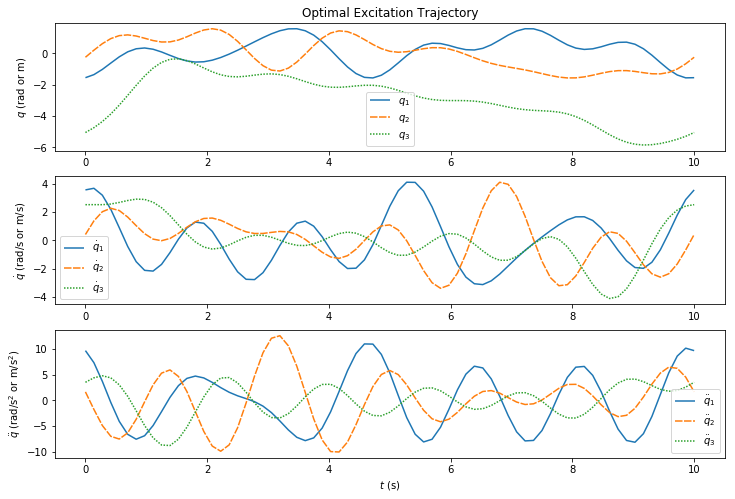

In [29]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## Save trajectory for later use

In [12]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [13]:
dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

# Data processing

In [14]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

[3.64603564e-02 1.43602738e-09 5.00000000e-01 2.92436979e-09
 3.39936474e-10 2.72499406e-02 8.58244868e-09 2.05598107e-09
 2.80364249e-01 5.16672017e-01 1.26418169e-09 8.83579487e-02
 1.14781966e-09 8.04578709e-02 1.60463662e-07 8.61035744e-02
 7.28152249e-02 1.27375334e-09 5.95909142e-10 1.43222416e-09]
[2.30333054e-07 1.41954940e+00 2.79916260e-08 6.45060323e-01
 1.19978023e+01 1.73539221e-07 1.08548294e+00 5.75693926e+00
 4.44007750e-08 2.46719400e-08 7.92091494e+00 1.05360369e-07
 7.49808918e+00 9.24790451e-08 2.35459420e-01 1.02979630e-07
 3.81294434e-08 7.92366213e+00 1.17801337e+01 4.57736094e+00]


## Load data

In [15]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [16]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


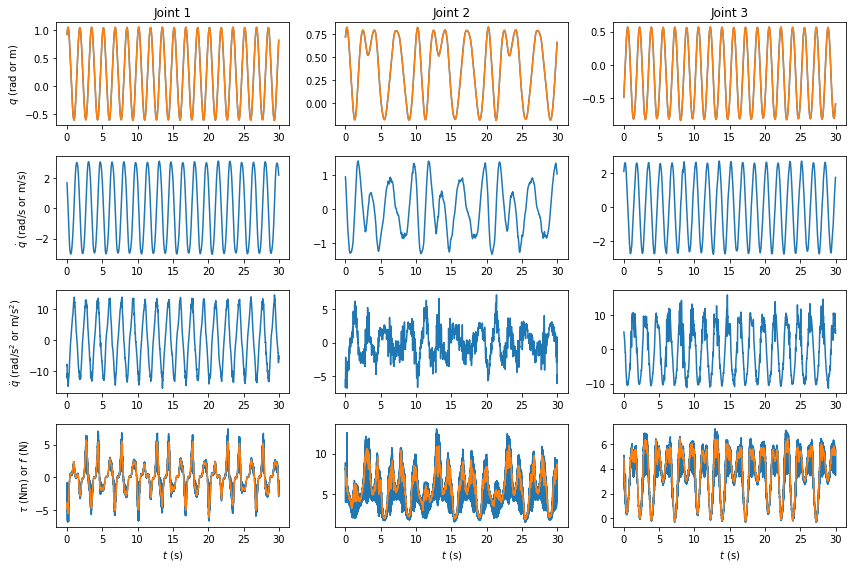

In [30]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [31]:
traj_optimizer.x_result

array([ 0.14801026, -0.15569937, -0.15030984,  0.07761556,  1.        ,
       -1.        ,  1.        ,  0.14572737,  0.99345113, -0.56727358,
        1.        ,  1.        ,  1.        , -0.07607172,  0.58985184,
        0.72925777,  0.42755897, -0.54124032,  0.99987142,  1.        ,
        0.14903518, -0.46186296,  0.51079767,  0.21723748, -1.        ,
        0.99908486, -2.93415229,  1.        ,  0.96954552,  0.77705583,
        0.22174516, -0.30394525, -0.70986871,  0.56464441,  0.79147366,
        0.78097593,  0.43827533,  0.34924382, -0.39856017])

# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [32]:
base_param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [33]:
print(W_b.shape, tau_s.shape)

((17970, 15), (17970,))


In [34]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [35]:
xb_ols

array([ 7.21406441e-02,  7.79418804e-04,  4.51759594e-01, -2.03789196e-02,
        1.42708260e-02,  8.39004192e-01, -5.50129960e-04,  3.04222130e-03,
        1.04918787e-01,  1.21380433e-04,  1.30898057e-01, -9.80113090e-04,
        4.97529618e-02,  3.10781502e-01,  1.79097965e-01])

## Compare measured torque and predicted torque

### Generate predicted torque

In [36]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Evaluate regression

In [37]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0022718597256644974
standard deviation of xb using OLS:
[2.06990051e-04 6.13950613e-05 8.17399761e-05 7.55993668e-05
 1.66379760e-04 3.92365726e-04 7.93194379e-05 1.63771907e-04
 1.70608326e-04 2.14751179e-04 1.22162924e-04 1.21574894e-04
 1.61095358e-04 4.06769460e-04 4.73460573e-04]
percentage of standard deviation of xb using OLS: 
[2.86925703e-03 7.87703106e-02 1.80936890e-04 3.70968472e-03
 1.16587337e-02 4.67656454e-04 1.44183091e-01 5.38330027e-02
 1.62609892e-03 1.76924050e+00 9.33267662e-04 1.24041700e-01
 3.23790487e-03 1.30885994e-03 2.64358432e-03]


### Plot measured torque and predicted torque

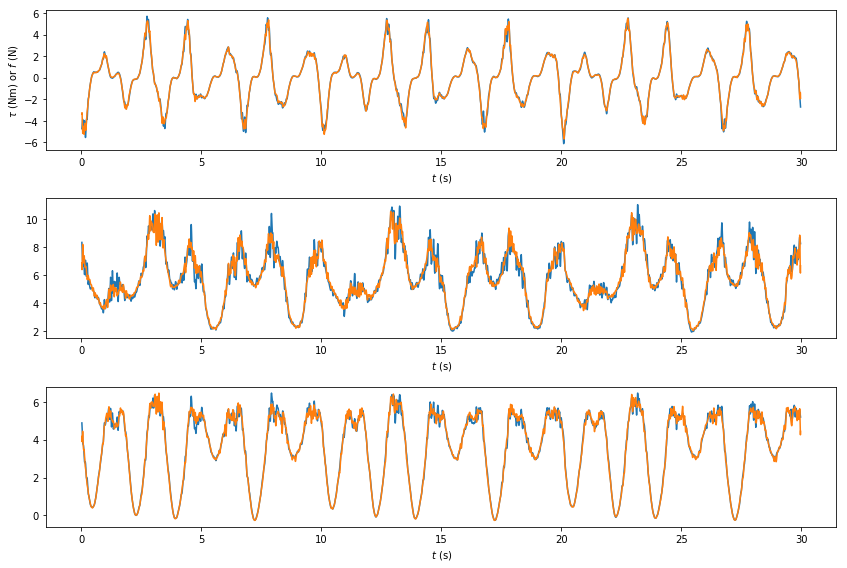

In [38]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

In [39]:
robot_def.params

[L1xx, L1xy, L1xz, L1yy, L1yz, L1zz, l1x, l1y, l1z, m₁, L2xx, L2xy, L2xz, L2yy
, L2yz, L2zz, l2x, l2y, l2z, m₂, L3xx, L3xy, L3xz, L3yy, L3yz, L3zz, l3x, l3y,
 l3z, m₃]

## Convex optimization

In [85]:
#from identification import SDPOpt
import cvxpy as cp

# sdp_opt = SDPOpt(W_b, tau_s, None)
# sdp_opt.solve()
m, n = W_b.shape
sdp_x = cp.Variable(n)
sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
sdp_constraints = []
sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

result = sdp_prob.solve(solver=cp.OSQP)

print(sdp_x.value)

SolverError: The solver OSQP is not installed.

In [45]:
xb_ols

array([ 7.21406441e-02,  7.79418804e-04,  4.51759594e-01, -2.03789196e-02,
        1.42708260e-02,  8.39004192e-01, -5.50129960e-04,  3.04222130e-03,
        1.04918787e-01,  1.21380433e-04,  1.30898057e-01, -9.80113090e-04,
        4.97529618e-02,  3.10781502e-01,  1.79097965e-01])

### Generate regressor matrix for base parameters

In [73]:
std_param_num = len(robot_def.params)
H_func = dyn.H_func
W, tau_s = gen_regressor(std_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [74]:
sdp_opt_std = SDPOpt(W, tau_s, None)
sdp_opt_std.solve()

(17970, 30)
(17970,)


TypeError: reduce() takes at most 5 arguments (6 given)

In [47]:
robot_def.params

[L1xx, L1xy, L1xz, L1yy, L1yz, L1zz, l1x, l1y, l1z, m₁, L2xx, L2xy, L2xz, L2yy
, L2yz, L2zz, l2x, l2y, l2z, m₂, L3xx, L3xy, L3xz, L3yy, L3yz, L3zz, l3x, l3y,
 l3z, m₃]